<img src="https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/imagens/logo_nlportugues.png"   width="150" align="right">

# EP 2: Transformers, Regressão e Quantização

#### MAC5725 - Linguística Computacional

______________

## <font color='3474eb'> Preparação do ambiente </font>







### Importa as bibliotecas necessárias



In [1]:
!pip install transformers[torch] tokenizers datasets
!pip install accelerate -U
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import torch, gc, random, datasets
from datasets import load_dataset
from transformers.file_utils import is_tf_available, is_torch_available
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import evaluate

### Define parâmetros usados pelo programa


In [3]:
SEED = 4238

# Caminho para download do corpus B2W
# B2W_CORPUS_SRC = "https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv"
B2W_CORPUS_SRC = "https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/Semana%2003/data/b2w-10k.csv"
B2W_CORPUS_DEST = "data/b2w-full.csv"

# Proporção de treino, validação e teste.
TRAIN_SIZE = 0.70
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15

# Caminho para os arquivos de treino, validação e teste.
TRAIN_CSV = "data/b2w_train.csv"
VALIDATION_CSV = "data/b2w_validation.csv"
TEST_CSV = "data/b2w_test.csv"

# Tamanho das sentenças.
MAX_LENGTH = 64

# Define o modelo que será usado
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
# MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'

# Número de épocas de treinamento.
NUM_EPOCHS = 10

### Importando os dados como um dataframe

Utilizaremos o dataset **B2W-Reviews01**, que contém cerca de 130k avaliações de produtos de uma plataforma de comércio eletrônico. Disponível [neste link](https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv).


In [4]:
# Cria pasta de destino
!mkdir -p data

# Dataset completo
!curl {B2W_CORPUS_SRC} --output {B2W_CORPUS_DEST}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3919k  100 3919k    0     0  7048k      0 --:--:-- --:--:-- --:--:-- 7049k


## <font color='3474eb'> Limpeza e particionamento dos dados </font>

Nesta etapa os dados são extraídos do arquivo csv, em seguida, são gerados os conjuntos de treinamento, validação e teste.

Amostras por classe (quantização não balanceada):
 1    9946
0      37
2       8
Name: label1, dtype: int64
Amostras por classe (quantização balanceada):
 0    3331
1    3330
2    3330
Name: label2, dtype: int64
density - max: 1.0, min: 0.008928571428571428


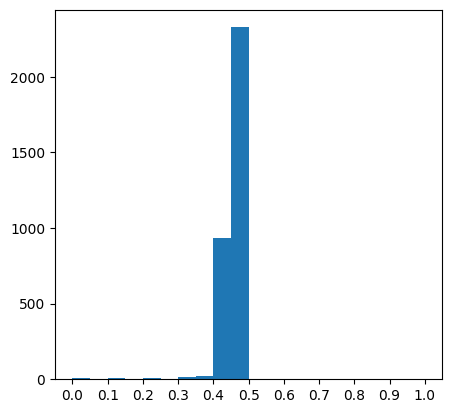

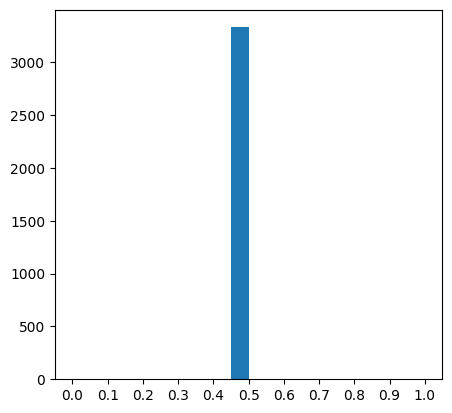

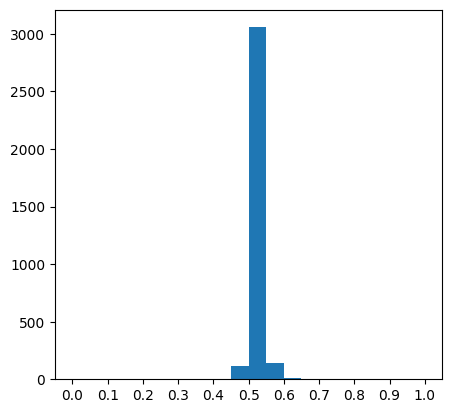

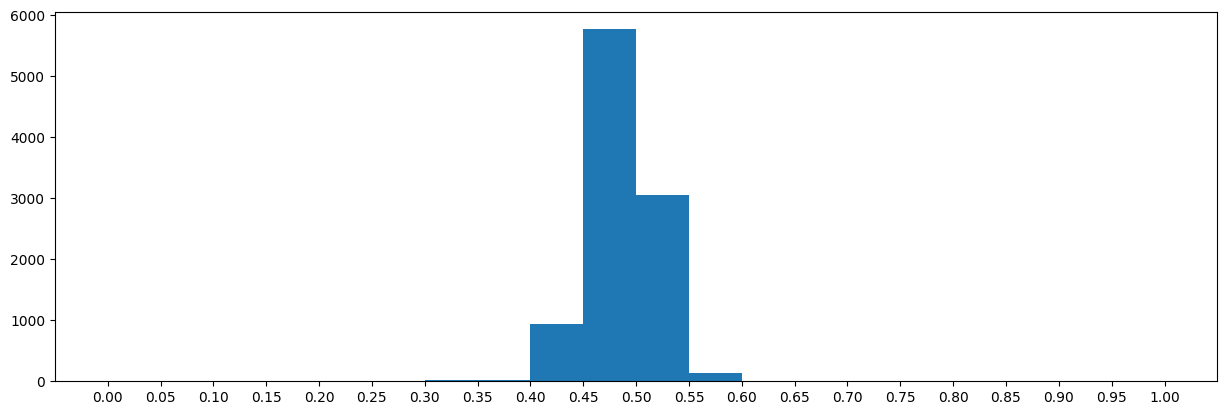


Corpus B2W - filtrado:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9991 entries, 9572 to 7504
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review_text         9991 non-null   object 
 1   density             9991 non-null   float64
 2   first_word_density  9991 non-null   float64
 3   last_word_density   9991 non-null   float64
 4   label1              9991 non-null   int64  
 5   label2              9991 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 546.4+ KB
None


,review_text,density,first_word_density,last_word_density,label1,label2
3321,A pressão d'agua aqui em casa é pouca. Não fic...,0.607843,1.000000,0.625000,1,2
1870,A bateria que recebi é pior do que a que eu us...,0.612245,1.000000,0.500000,1,2
5989,Vou cancelar pedido. Não recebi mercadoria ain...,0.614286,0.666667,0.894737,1,2
4304,"gostei muitoooooo, recomendou ...................",0.615385,0.500000,0.000000,1,2
89,Pequeno compacto mais muitoooooooo eficiente. ...,0.633333,0.571429,0.444444,1,2
5748,"Gostei da cor , Gostei da marca . RecomendooRe...",0.634921,0.500000,0.743590,1,2
6321,Chegou antes da data prevista ótimo produto bo...,0.644068,0.500000,0.954545,1,2
8240,iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii...,0.714988,0.714988,0.714988,2,2
4032,Muito bom produto Recomendo Entrega rapida Áa...,0.733333,0.600000,1.000000,2,2
307,minha filha adorou o produto.ooooooooooooooooo...,0.769231,0.400000,0.885714,2,2


In [5]:
def calculate_vowel_density(sentence):
    vowels = 'aeiouáàãâéèẽêíìĩîóòõôúùũûAEIOUÁÀÃÂÉÈẼÊÍÌĨÎÓÒÕÔÚÙŨÛ'
    consonants = 'bcçdfghjklmnpqrstvwxyzBCÇDFGHJKLMNPQRSTVWXYZ'

    num_vowels = sum(sentence.count(v) for v in vowels)
    num_consonants = sum(sentence.count(c) for c in consonants)
    num_letters = num_vowels + num_consonants

    return num_vowels/num_letters if num_letters > 0 else 0.0

def prepare_data(b2w_corpus):
    '''
    Recebe o corpus (DataFrame pandas), seleciona a coluna contendo o texto de
    avalição, filtra os valores nulos.

    Em seguida, adiciona uma coluna com a densidade de vogais da sentença.

    '''

    # Seleciona coluna de reviews.
    b2w_data = b2w_corpus.loc[:, ['review_text']]

    # Descarta linhas com dados nulos.
    b2w_data = b2w_data.dropna()

    # Adiciona coluna com densidade de vogais.
    density = []
    labels = []
    first_word_density = []
    last_word_density = []
    vowels = 'aeiouáàãâéèẽêíìĩîóòõôúùũûAEIOUÁÀÃÂÉÈẼÊÍÌĨÎÓÒÕÔÚÙŨÛ'
    consonants = 'bcçdfghjklmnpqrstvwxyzBCÇDFGHJKLMNPQRSTVWXYZ'

    for sentence in b2w_data['review_text']:
        # Limpa a sentença, deixando apenas vogais, consoantes e espaço
        clean_sentence = ''.join(char for char in sentence if char in vowels + consonants + ' ')

        # Densidade de vogais na sentença completa.
        d = calculate_vowel_density(clean_sentence)
        density.append(d)

        # Densidade de vogais na primeira e na última palavra.
        words = clean_sentence.split(' ')
        first_word_density.append(calculate_vowel_density(words[0]))
        last_word_density.append(calculate_vowel_density(words[-1]))

        # Quantização não balanceada - classifica de acordo com densidade
        if d < 1/3:
            labels.append(0)
        elif d < 2/3:
            labels.append(1)
        else:
            labels.append(2)

    b2w_data['density'] = density
    b2w_data['first_word_density'] = first_word_density
    b2w_data['last_word_density'] = last_word_density
    b2w_data['label1'] = labels

    # Seleciona linhas com densidade > 0 para evitar problemas na métrica MAPE.
    # Na base de 10k amostras, apenas 8 caem nesse caso ()
    b2w_data = b2w_data.loc[(b2w_data['density'] > 0)]

    # Quantização balanceada - ordena por densidade e divide 1/3 para cada classe
    b2w_data.sort_values(by='density', ascending=True, inplace=True)
    labels = []
    count = 0
    size = len(b2w_data['density'])
    for d in b2w_data['density']:
        if count < size/3:
            labels.append(0)
        elif count < 2*size/3:
            labels.append(1)
        else:
            labels.append(2)
        count += 1

    b2w_data['label2'] = labels

    # Mostra informações dos dados filtrados.
    print("Amostras por classe (quantização não balanceada):\n", b2w_data['label1'].value_counts())
    print("Amostras por classe (quantização balanceada):\n", b2w_data['label2'].value_counts())
    print(f"density - max: {max(b2w_data['density'])}, min: {min(b2w_data['density'])}")
    # print(b2w_data.tail(15))

    c0 = b2w_data[b2w_data['label2'] == 0]
    plt.figure().set_figwidth(5)
    plt.hist(c0['density'], bins=np.arange(0, 1.05, 0.05))
    plt.xticks(np.arange(0, 1.05, 0.1))
    plt.show()

    c1 = b2w_data[b2w_data['label2'] == 1]
    plt.figure().set_figwidth(5)
    plt.hist(c1['density'], bins=np.arange(0, 1.05, 0.05))
    plt.xticks(np.arange(0, 1.05, 0.1))
    plt.show()

    c2 = b2w_data[b2w_data['label2'] == 2]
    plt.figure().set_figwidth(5)
    plt.hist(c2['density'], bins=np.arange(0, 1.05, 0.05))
    plt.xticks(np.arange(0, 1.05, 0.1))
    plt.show()

    plt.figure().set_figwidth(15)
    plt.hist(b2w_data['density'], bins=np.arange(0, 1.05, 0.05))
    plt.xticks(np.arange(0, 1.05, 0.05))
    plt.show()

    return b2w_data

def split_data(csv_input_path):
    '''
    Carrega os dados do arquivo de entrada, filtra os dados, particiona os dados
    para treinamento, validação e teste. Salva os dados em arquivos e retorna os
    dados como saída.
    '''

    # Carrega arquivo CSV.
    b2w_corpus = pd.read_csv(csv_input_path, usecols=['review_text'])

    # Filtra dados.
    b2w_filtered = prepare_data(b2w_corpus)
    print('\nCorpus B2W - filtrado:\n')
    print(b2w_filtered.info())

    # Divide a base em conjuntos de treinamento, validação e teste.
    pos_1 = int(TRAIN_SIZE * len(b2w_filtered))
    pos_2 = int((TRAIN_SIZE + VALIDATION_SIZE) * len(b2w_filtered))
    train, validation, test = np.split(
        b2w_filtered.sample(frac=1, random_state=SEED), # amostra pseudo-aleatória do dataframe, frac=1 => 100%
        [pos_1, pos_2])                                 # divide em 3 partições, equivalentes a [0:pos_1], [pos_1:pos_2], [pos_2:end]

    # Salva arquivos de treino, validação e teste
    train.to_csv(TRAIN_CSV)
    validation.to_csv(VALIDATION_CSV)
    test.to_csv(TEST_CSV)

    return train, validation, test, b2w_filtered

################################################################################

# Particiona os dados de treinamento, validação e teste.
train, validation, test, b2w_filtered = split_data(B2W_CORPUS_DEST)

# Exibe resultado
b2w_filtered.tail(15)

## <font color='3474eb'>Baseline</font>


**Define funções para calcular e exibir métricas**

In [6]:
# Carrega métricas da biblioteca evaluate do HuggingFace
def eval_func(metric, predictions, references, **kwargs):
    # https://huggingface.co/evaluate-metric
    metrics = evaluate.load(metric)
    temp = metrics.compute(predictions=predictions, references=references,
                           **kwargs)
    return temp[metric]

# Calcula as métricas na regressão.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    predictions = logits

    # Resultados das métricas
    results = {}

    # RSME - raiz quadrada do erro quadrático médio
    results["rmse"] = eval_func("mse", predictions, labels, squared=False)

    # MAE - erro absoluto médio
    results["mae"] = eval_func("mae", predictions, labels)

    # MAPE - Mean Absolute Percentage Error
    results["mape"] = eval_func("mape", predictions, labels)

    # Correlação de Pearson
    results["pearsonr"] = eval_func("pearsonr", predictions, labels)

    # MSE - erro quadrático médio
    results["mse"] = eval_func("mse", predictions, labels, squared=True)

    # R2 - R-squared value
    # Nota: há um bug em na métrica, por isso foi calculada separadamente
    # https://github.com/huggingface/evaluate/tree/main/metrics/r_squared
    # https://huggingface.co/spaces/evaluate-metric/r_squared/discussions/1
    metrics = evaluate.load("r_squared")
    results["r_squared"] = metrics.compute(predictions=predictions, references=labels)

    return results

# Calcula as métricas na classificação.
def compute_metrics_classification(eval_pred):
    logits, labels = eval_pred
    true_labels = labels.reshape(-1, 1).ravel()

    # As predições serão representada pela classe de maior probabilidade
    # (maior valor no array de logits)
    predicted_labels = np.argmax(logits, axis=-1).ravel()

    num_classes = 3
    metrics = {}

    for label in range(num_classes):
        true_positive = sum((predicted == label and true == label) for predicted, true in zip(predicted_labels, true_labels))
        true_negative = sum((predicted != label and true != label) for predicted, true in zip(predicted_labels, true_labels))
        false_positive = sum((predicted == label and true != label) for predicted, true in zip(predicted_labels, true_labels))
        false_negative = sum((predicted != label and true == label) for predicted, true in zip(predicted_labels, true_labels))

        # Acurácia
        accuracy = (true_positive + true_negative) / len(predicted_labels) if len(predicted_labels) > 0 else 0.0
        metrics[f"accuracy_c{label}"] = accuracy

        # Sensibilidade
        sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        metrics[f"sensitivity_c{label}"] = sensitivity

        # Especificidade
        specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0.0
        metrics[f"specificity_c{label}"] = specificity

    # Acurácia global
    metrics["accuracy"] = eval_func("accuracy", predicted_labels, true_labels)

    # Sensibilidade global
    metrics["sensitivity"] = sum(metrics[f"sensitivity_c{label}"] for label in range(num_classes)) / num_classes

    # Especificidade global
    metrics["specificity"] = sum(metrics[f"specificity_c{label}"] for label in range(num_classes)) / num_classes

    return metrics

# Define função para exibir métricas de avaliação.
def show_metrics(metrics, prefix=''):
    print("  > MSE      : %.4f" % metrics[f'{prefix}mse'])
    print("  > RMSE     : %.4f" % metrics[f'{prefix}rmse'])
    print("  > MAE      : %.4f" % metrics[f'{prefix}mae'])
    print("  > MAPE     : %.4f" % metrics[f'{prefix}mape'])
    print("  > R-Squared: %.4f" % metrics[f'{prefix}r_squared'])
    print("  > Pearson  : %.4f" % metrics[f'{prefix}pearsonr'])
    print("\n")

# Define função para exibir métricas de avaliação.
def show_metrics_classification(metrics, prefix=''):
    print("  > Accuracy   : %.4f" % metrics[f'{prefix}accuracy'])
    print("  > Sensitivity: %.4f" % metrics[f'{prefix}sensitivity'])
    print("  > Specificity: %.4f" % metrics[f'{prefix}specificity'])

    for label in [0, 1, 2]:
        print("\n")
        print("  > C%d Accuracy   : %.4f" % (label, metrics[f'{prefix}accuracy_c{label}']))
        print("  > C%d Sensitivity: %.4f" % (label, metrics[f'{prefix}sensitivity_c{label}']))
        print("  > C%d Specificity: %.4f" % (label, metrics[f'{prefix}specificity_c{label}']))

    print("\n")


**Calcula e exibe o baseline**

In [7]:
print("Baseline:\n")
print("  > Média da DV no córpus completo: %.2f" % b2w_filtered['density'].mean())
print("  > Média da DV na primeira palavra da sentença: %.2f" % b2w_filtered['first_word_density'].mean())
print("  > Média da DV na última palavra da sentença: %.2f" % b2w_filtered['last_word_density'].mean())
print("\n")

full_corpus = np.full(test['density'].shape, b2w_filtered['density'].mean())

metrics_full_corpus = compute_metrics((full_corpus, test['density'].ravel()))
metrics_first_column = compute_metrics((test['first_word_density'].ravel(), test['density'].ravel()))
metrics_last_column = compute_metrics((test['last_word_density'].ravel(), test['density'].ravel()))

print("\nBaseline - DV córpus:\n")
show_metrics(metrics_full_corpus)

print("Baseline - DV primeira palavra:\n")
show_metrics(metrics_first_column)

print("Baseline - DV última palavra:\n")
show_metrics(metrics_last_column)


Baseline:

  > Média da DV no córpus completo: 0.48
  > Média da DV na primeira palavra da sentença: 0.57
  > Média da DV na última palavra da sentença: 0.43




/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))



Baseline - DV córpus:

  > MSE      : 0.0014
  > RMSE     : 0.0377
  > MAE      : 0.0233
  > MAPE     : 0.0621
  > R-Squared: -0.0000
  > Pearson  : nan


Baseline - DV primeira palavra:

  > MSE      : 0.0476
  > RMSE     : 0.2183
  > MAE      : 0.1412
  > MAPE     : 0.2956
  > R-Squared: -32.5110
  > Pearson  : 0.2170


Baseline - DV última palavra:

  > MSE      : 0.0222
  > RMSE     : 0.1488
  > MAE      : 0.0933
  > MAPE     : 0.1940
  > R-Squared: -14.5810
  > Pearson  : 0.2810




## <font color='3474eb'> Tokenização e Codificação das sentenças</font>




**Define funções auxiliares**

In [8]:
# Cria objeto com dados que serão usados no treinamento da regressão
class MakeTorchDataForRegression(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        item["labels"] = float(item["labels"])
        return item

    def __len__(self):
        return len(self.labels)

# Cria objeto com dados que serão usados no treinamento da classificação
class MakeTorchDataForClassification(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        item["labels"] = item["labels"]
        return item

    def __len__(self):
        return len(self.labels)

**Tokeniza e codifica sentenças**

In [9]:
torch.manual_seed(SEED)

# Define valores usados para treinamento, validação e testes.
x_train = train['review_text'].tolist()
x_val = validation['review_text'].tolist()
x_test = test['review_text'].tolist()

# Define o tokenizador.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False, seed=SEED)

# Codifica o texto.
train_encodings = tokenizer(x_train, truncation=True, padding=True, max_length=MAX_LENGTH)
validation_encodings = tokenizer(x_val, truncation=True, padding=True, max_length=MAX_LENGTH)
test_encodings = tokenizer(x_test, truncation=True, padding=True, max_length=MAX_LENGTH)


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## <font color='3474eb'>Tarefa 1 - Regressão de densidade de vogais</font>




**Preparação do modelo e treinamento**


In [10]:
# y_XXXX define os valores usados como label para treinamento
# 'density' corresponde ao valor da DV, usada na regressão
y_val = validation['density']
y_train = train['density']
y_test = test['density']

# Converte os dados tokenizados em um torch Dataset.
# y_XXXX define os valores usados como label para regressão
train_dataset = MakeTorchDataForRegression(train_encodings, y_train.ravel())
validation_dataset = MakeTorchDataForRegression(validation_encodings, y_val.ravel())
test_dataset = MakeTorchDataForRegression(test_encodings, y_test.ravel())

# Carrega o modelo - para regressão, num_labels=1
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1).to("cuda")

# Especifica os argumentos para o treinamento.
training_args = TrainingArguments(
    output_dir ='./results',
    num_train_epochs = NUM_EPOCHS,
    per_device_train_batch_size = 64, # default: 8
    per_device_eval_batch_size = 64, # default: 8
    weight_decay = 0.001, # default: 0.0
    learning_rate = 5e-5, # default: 5e-5
    logging_dir = './logs',
    save_total_limit = 2, # default: 5?
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
)

# Prepara o Trainer.
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = validation_dataset,
    compute_metrics = compute_metrics,
)

# Treina o modelo.
trainer.train()

# Calcula métricas de avaliação.
eval = trainer.evaluate()

# Calcula métricas de avaliação na partição de teste.
prediction = trainer.predict(test_dataset=test_dataset)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse,Mae,Mape,Pearsonr,Mse,R Squared
1,No log,0.000932,0.030532,0.019911,0.049430,0.635104,0.000932,0.328000
2,No log,0.000850,0.029154,0.021055,0.048326,0.724347,0.000850,0.387000
3,No log,0.000882,0.029700,0.023139,0.052639,0.813672,0.000882,0.364000
4,No log,0.000521,0.022832,0.015551,0.037408,0.825803,0.000521,0.624000
5,0.003300,0.000367,0.019159,0.013765,0.031136,0.861640,0.000367,0.735000
6,0.003300,0.000415,0.020383,0.013586,0.031642,0.853869,0.000415,0.700000
7,0.003300,0.000338,0.018386,0.012331,0.028771,0.869652,0.000338,0.756000
8,0.003300,0.000339,0.018399,0.012160,0.028215,0.874743,0.000339,0.756000
9,0.003300,0.000363,0.019063,0.012548,0.029495,0.871016,0.000363,0.738000
10,0.000500,0.000373,0.019321,0.012720,0.029958,0.870627,0.000373,0.731000


In [11]:
print("Avaliação na partição de validação:\n")
show_metrics(eval, prefix='eval_')

print("Avaliação na partição de teste:\n")
show_metrics(prediction.metrics, prefix='test_')

Avaliação na partição de validação:

  > MSE      : 0.0009
  > RMSE     : 0.0305
  > MAE      : 0.0199
  > MAPE     : 0.0494
  > R-Squared: 0.3280
  > Pearson  : 0.6351


Avaliação na partição de teste:

  > MSE      : 0.0007
  > RMSE     : 0.0272
  > MAE      : 0.0199
  > MAPE     : 0.0484
  > R-Squared: 0.4790
  > Pearson  : 0.7478




## <font color='3474eb'>Tarefa 2 - Quantização não balanceada</font>


In [12]:
# y_XXXX define os valores usados como label para classificação
# 'label1' corresponde à coluna que representa as classes não balanceadas
y_train = train['label1']
y_val = validation['label1']
y_test = test['label1']

# Converte os dados tokenizados em um torch Dataset.
train_dataset = MakeTorchDataForClassification(train_encodings, y_train.ravel())
validation_dataset = MakeTorchDataForClassification(validation_encodings, y_val.ravel())
test_dataset = MakeTorchDataForClassification(test_encodings, y_test.ravel())

# Carrega o modelo.
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to("cuda")

# Especifica os argumentos para o treinamento.
training_args = TrainingArguments(
    output_dir ='./results',
    num_train_epochs = NUM_EPOCHS,
    per_device_train_batch_size = 64, # default: 8
    per_device_eval_batch_size = 64, # default: 8
    weight_decay = 0.001, # default: 0.0
    learning_rate = 5e-5, # default: 5e-5
    logging_dir = './logs',
    save_total_limit = 2, # default: None
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
)

# Prepara o Trainer.
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = validation_dataset,
    compute_metrics = compute_metrics_classification,
)

# Treina o modelo.
trainer.train()

# Calcula métricas de avaliação.
eval_label1 = trainer.evaluate()

# Calcula métricas de avaliação na partição de teste.
prediction_label1 = trainer.predict(test_dataset=test_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy C0,Sensitivity C0,Specificity C0,Accuracy C1,Sensitivity C1,Specificity C1,Accuracy C2,Sensitivity C2,Specificity C2,Accuracy,Sensitivity,Specificity
1,No log,0.028565,0.995997,0.142857,1.000000,0.995330,1.000000,0.125000,0.999333,0.000000,1.000000,0.995330,0.380952,0.708333
2,No log,0.014476,0.996664,0.285714,1.000000,0.995997,1.000000,0.250000,0.999333,0.000000,1.000000,0.995997,0.428571,0.750000
3,No log,0.009038,0.997999,0.857143,0.998660,0.998666,0.999329,0.875000,0.999333,0.000000,1.000000,0.997999,0.618824,0.957887
4,No log,0.009839,0.997999,0.571429,1.000000,0.997332,1.000000,0.500000,0.999333,0.000000,1.000000,0.997332,0.523810,0.833333
5,0.017800,0.010632,0.997999,0.571429,1.000000,0.997999,0.999329,0.750000,0.998666,1.000000,0.998665,0.997332,0.856919,0.916222
6,0.017800,0.012488,0.997999,0.571429,1.000000,0.997999,0.999329,0.750000,0.998666,1.000000,0.998665,0.997332,0.856919,0.916222
7,0.017800,0.012195,0.997999,0.571429,1.000000,0.997999,0.999329,0.750000,0.998666,1.000000,0.998665,0.997332,0.856919,0.916222
8,0.017800,0.012850,0.997999,0.571429,1.000000,0.997999,0.999329,0.750000,0.998666,1.000000,0.998665,0.997332,0.856919,0.916222
9,0.017800,0.012786,0.997999,0.571429,1.000000,0.997999,0.999329,0.750000,0.998666,1.000000,0.998665,0.997332,0.856919,0.916222
10,0.000600,0.012910,0.997999,0.571429,1.000000,0.997999,0.999329,0.750000,0.998666,1.000000,0.998665,0.997332,0.856919,0.916222


In [13]:
print("Avaliação na partição de validação:\n")
show_metrics_classification(eval_label1, prefix='eval_')

print("Avaliação na partição de teste:\n")
show_metrics_classification(prediction_label1.metrics, prefix='test_')

Avaliação na partição de validação:

  > Accuracy   : 0.9980
  > Sensitivity: 0.6188
  > Specificity: 0.9579


  > C0 Accuracy   : 0.9980
  > C0 Sensitivity: 0.8571
  > C0 Specificity: 0.9987


  > C1 Accuracy   : 0.9987
  > C1 Sensitivity: 0.9993
  > C1 Specificity: 0.8750


  > C2 Accuracy   : 0.9993
  > C2 Sensitivity: 0.0000
  > C2 Specificity: 1.0000


Avaliação na partição de teste:

  > Accuracy   : 0.9947
  > Sensitivity: 0.8318
  > Specificity: 0.9568


  > C0 Accuracy   : 0.9953
  > C0 Sensitivity: 1.0000
  > C0 Specificity: 0.9953


  > C1 Accuracy   : 0.9947
  > C1 Sensitivity: 0.9953
  > C1 Specificity: 0.8750


  > C2 Accuracy   : 0.9993
  > C2 Sensitivity: 0.5000
  > C2 Specificity: 1.0000




## <font color='3474eb'>Tarefa 3 - Quantização balanceada</font>


In [14]:
# y_XXXX define os valores usados como label para classificação
# 'label2' corresponde à coluna que representa as classes balanceadas
y_train = train['label2']
y_val = validation['label2']
y_test = test['label2']

# Converte os dados tokenizados em um torch Dataset.
train_dataset = MakeTorchDataForClassification(train_encodings, y_train.ravel())
validation_dataset = MakeTorchDataForClassification(validation_encodings, y_val.ravel())
test_dataset = MakeTorchDataForClassification(test_encodings, y_test.ravel())

# Carrega o modelo.
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to("cuda")

# Especifica os argumentos para o treinamento.
training_args = TrainingArguments(
    output_dir ='./results',
    num_train_epochs = NUM_EPOCHS,
    per_device_train_batch_size = 64, # default: 8
    per_device_eval_batch_size = 64, # default: 8
    weight_decay = 0.001, # default: 0.0
    learning_rate = 5e-5, # default: 5e-5
    logging_dir = './logs',
    save_total_limit = 2, # default: None
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
)

# Prepara o Trainer.
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = validation_dataset,
    compute_metrics = compute_metrics_classification,
)

# Treina o modelo.
trainer.train()

# Calcula métricas de avaliação.
eval_label2 = trainer.evaluate()

# Calcula métricas de avaliação na partição de teste.
prediction_label2 = trainer.predict(test_dataset=test_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy C0,Sensitivity C0,Specificity C0,Accuracy C1,Sensitivity C1,Specificity C1,Accuracy C2,Sensitivity C2,Specificity C2,Accuracy,Sensitivity,Specificity
1,No log,0.779128,0.817879,0.718504,0.868819,0.689793,0.342742,0.861416,0.779853,0.868687,0.736056,0.643763,0.643311,0.822097
2,No log,0.670997,0.843229,0.769685,0.880928,0.725150,0.584677,0.794616,0.840560,0.757576,0.881474,0.704470,0.703979,0.852340
3,No log,0.702167,0.849900,0.629921,0.962664,0.731154,0.741935,0.725823,0.859907,0.791919,0.893426,0.720480,0.721259,0.860638
4,No log,0.920321,0.845230,0.604331,0.968718,0.701801,0.596774,0.753739,0.827218,0.862626,0.809761,0.687125,0.687910,0.844073
5,0.511500,0.935977,0.863242,0.734252,0.929364,0.731154,0.814516,0.689930,0.857238,0.628283,0.970120,0.725817,0.725684,0.863138
6,0.511500,1.044800,0.864576,0.681102,0.958628,0.739827,0.721774,0.748754,0.860574,0.795960,0.892430,0.732488,0.732945,0.866604
7,0.511500,1.167092,0.863242,0.763780,0.914228,0.741161,0.705645,0.758724,0.859239,0.725253,0.925299,0.731821,0.731559,0.866084
8,0.511500,1.283624,0.867912,0.702756,0.952573,0.743162,0.758065,0.735793,0.860574,0.747475,0.916335,0.735824,0.736098,0.868233
9,0.511500,1.372933,0.867912,0.692913,0.957619,0.739159,0.711694,0.752742,0.855237,0.789899,0.887450,0.731154,0.731502,0.865937
10,0.064000,1.358776,0.866578,0.704724,0.949546,0.745831,0.729839,0.753739,0.863242,0.779798,0.904382,0.737825,0.738120,0.869222


In [15]:
print("Avaliação na partição de validação:\n")
show_metrics_classification(eval_label2, prefix='eval_')

print("Avaliação na partição de teste:\n")
show_metrics_classification(prediction_label2.metrics, prefix='test_')

Avaliação na partição de validação:

  > Accuracy   : 0.7378
  > Sensitivity: 0.7381
  > Specificity: 0.8692


  > C0 Accuracy   : 0.8666
  > C0 Sensitivity: 0.7047
  > C0 Specificity: 0.9495


  > C1 Accuracy   : 0.7458
  > C1 Sensitivity: 0.7298
  > C1 Specificity: 0.7537


  > C2 Accuracy   : 0.8632
  > C2 Sensitivity: 0.7798
  > C2 Specificity: 0.9044


Avaliação na partição de teste:

  > Accuracy   : 0.7238
  > Sensitivity: 0.7256
  > Specificity: 0.8616


  > C0 Accuracy   : 0.8566
  > C0 Sensitivity: 0.6855
  > C0 Specificity: 0.9453


  > C1 Accuracy   : 0.7298
  > C1 Sensitivity: 0.6908
  > C1 Specificity: 0.7500


  > C2 Accuracy   : 0.8612
  > C2 Sensitivity: 0.8004
  > C2 Specificity: 0.8895




## Referências

* https://towardsdatascience.com/linear-regression-with-hugging-face-3883fe729324

* https://medium.com/ilb-labs-publications/fine-tuning-bert-for-a-regression-task-is-a-description-enough-to-predict-a-propertys-list-price-cf97cd7cb98a

* https://huggingface.co/docs/transformers/main_classes/trainer

* https://huggingface.co/neuralmind/bert-base-portuguese-cased

* https://medium.com/illumination/mape-vs-smape-when-to-choose-what-be51a170df16

* https://hyperskill.org/learn/step/26184

* https://github.com/huggingface/evaluate/tree/main/metrics

* https://huggingface.co/evaluate-metric

* https://stephenallwright.com/calculate-mape-with-0-values/

* https://towardsdatascience.com/evaluating-categorical-models-ii-sensitivity-and-specificity-e181e573cff8

* https://en.wikipedia.org/wiki/Sensitivity_and_specificity